# Introduction to Neural Networks 
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset. 

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

/Users/arminsh/miniconda3/envs/torch2/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/arminsh/miniconda3/envs/torch2/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/arminsh/miniconda3/envs/torch2/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <FF4CD76F-661C-3E38-91B4-8C3E88D7FE2E> /Users/arminsh/miniconda3/envs/torch2/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

/Users/arminsh/miniconda3/envs/torch2/lib/python3.9/site-packages/torchvision/datasets/mnist.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(os.path.

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

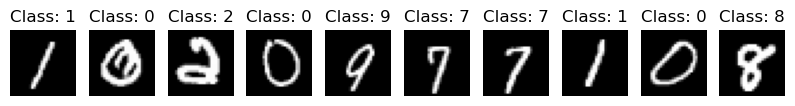

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week. 
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication. 

Note, like before, we consider multiple examples at once, adding another dimension to the input. 


 <img src="images/LinearModel_1.png"  align="center"/>
 


The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step. 

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5027149260838827, accuracy: 87.58749999999999
Epoch 0: val. loss: 0.4946149679574561, val. accuracy: 87.50833333333333
Epoch 1: training loss: 0.42203377636273703, accuracy: 88.98958333333333
Epoch 1: val. loss: 0.41241546514186456, val. accuracy: 88.78333333333333
Epoch 2: training loss: 0.38795572940508527, accuracy: 89.63125
Epoch 2: val. loss: 0.3778148499575067, val. accuracy: 89.45
Epoch 3: training loss: 0.36792863241831464, accuracy: 90.02916666666667
Epoch 3: val. loss: 0.35764446600954586, val. accuracy: 89.94166666666666
Epoch 4: training loss: 0.3543091497818629, accuracy: 90.36666666666666
Epoch 4: val. loss: 0.34406057206240104, val. accuracy: 90.25833333333333
CPU times: user 13.5 s, sys: 1.46 s, total: 15 s
Wall time: 14.1 s


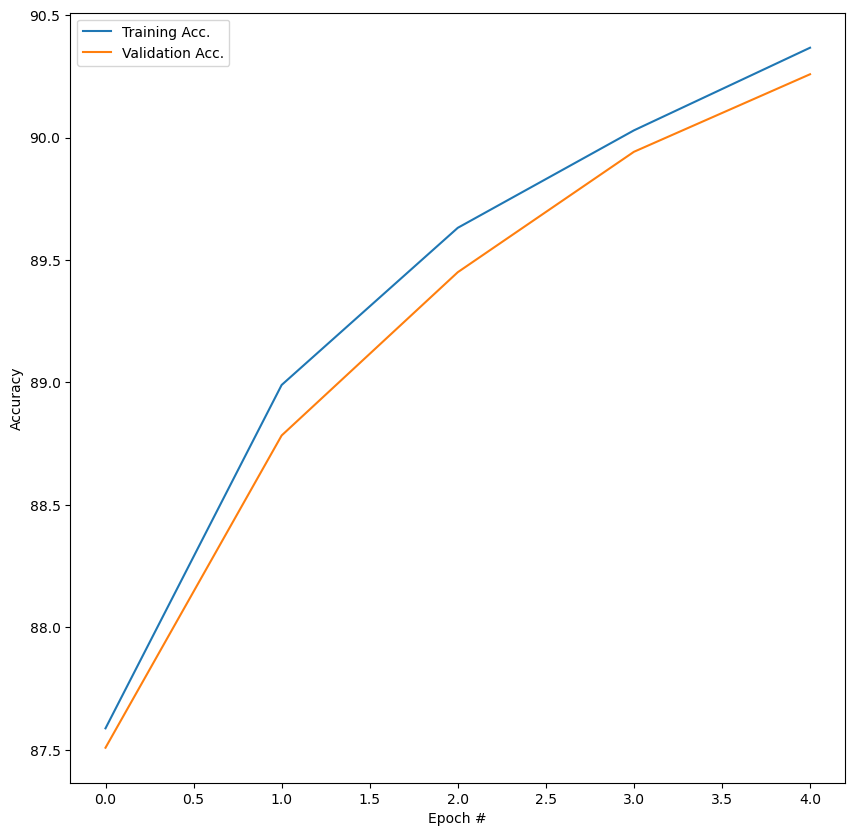

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

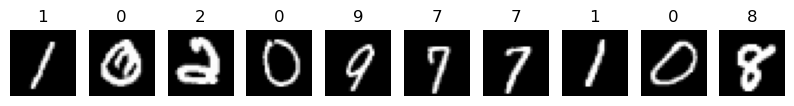

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc. 

Since the accuracy of the validation set has not plateaued yet, increasing the epochs can be helpful: Another 25 epochs with a larger learning rate gives

In [14]:
%%time
epochs = 25
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.10)

for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.33768116899331413, accuracy: 90.77708333333334
Epoch 0: val. loss: 0.3274450601732477, val. accuracy: 90.64999999999999
Epoch 1: training loss: 0.3260161211887995, accuracy: 91.04375
Epoch 1: val. loss: 0.31623896988148387, val. accuracy: 90.94166666666666
Epoch 2: training loss: 0.317620746254921, accuracy: 91.26041666666667
Epoch 2: val. loss: 0.3083474219162413, val. accuracy: 91.25
Epoch 3: training loss: 0.31118493219216664, accuracy: 91.41666666666667
Epoch 3: val. loss: 0.3024267822186998, val. accuracy: 91.425
Epoch 4: training loss: 0.3060336677233378, accuracy: 91.57708333333333
Epoch 4: val. loss: 0.29778898285424454, val. accuracy: 91.63333333333334
Epoch 5: training loss: 0.3017786657412847, accuracy: 91.69375
Epoch 5: val. loss: 0.2940402641258341, val. accuracy: 91.73333333333333
Epoch 6: training loss: 0.2981786085367203, accuracy: 91.77708333333334
Epoch 6: val. loss: 0.29093709429527853, val. accuracy: 91.725
Epoch 7: training loss: 0.2950746

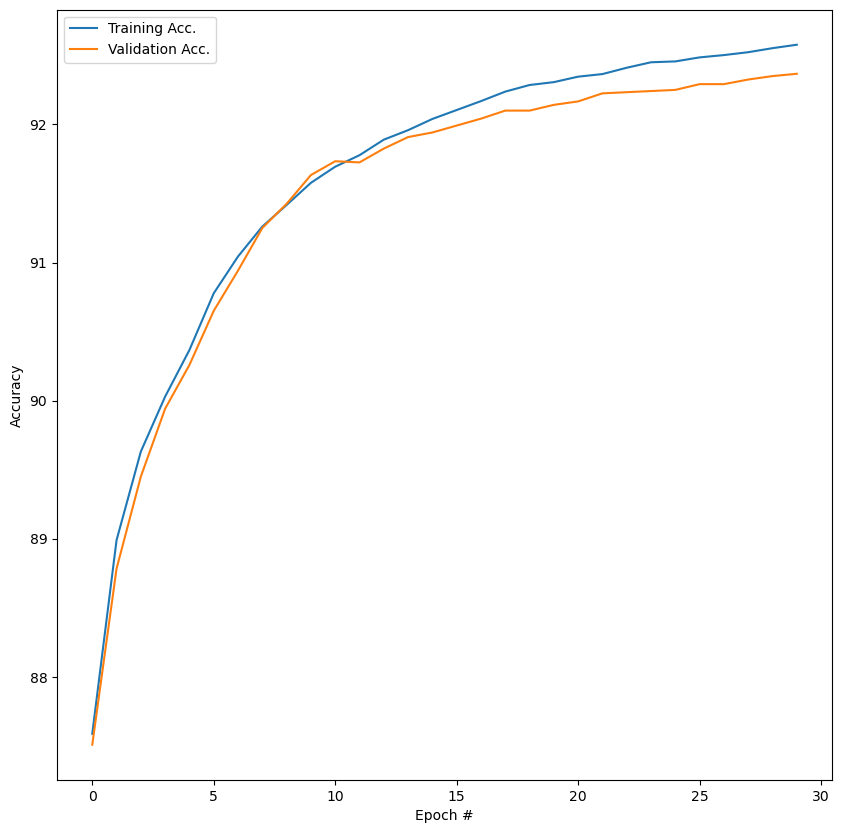

In [15]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(30), train_acc_all,label = 'Training Acc.' )
plt.plot(range(30), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

Reduce the learning rate and continue training for another 10 epochs

In [16]:
%%time
epochs = 10
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)

for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.26867059409618377, accuracy: 92.61666666666667
Epoch 0: val. loss: 0.26930310069880586, val. accuracy: 92.34166666666667
Epoch 1: training loss: 0.26855198001861574, accuracy: 92.63125
Epoch 1: val. loss: 0.2692259277435059, val. accuracy: 92.30833333333334
Epoch 2: training loss: 0.26845503542820615, accuracy: 92.62916666666666
Epoch 2: val. loss: 0.2691741463668803, val. accuracy: 92.31666666666666
Epoch 3: training loss: 0.2683647591670354, accuracy: 92.62916666666666
Epoch 3: val. loss: 0.2691251377951592, val. accuracy: 92.31666666666666
Epoch 4: training loss: 0.26827851035197575, accuracy: 92.62916666666666
Epoch 4: val. loss: 0.2690769187471968, val. accuracy: 92.325
Epoch 5: training loss: 0.2681949883302053, accuracy: 92.64166666666667
Epoch 5: val. loss: 0.2690294164609402, val. accuracy: 92.325
Epoch 6: training loss: 0.2681134103536606, accuracy: 92.64583333333334
Epoch 6: val. loss: 0.26898268324897645, val. accuracy: 92.325
Epoch 7: training los

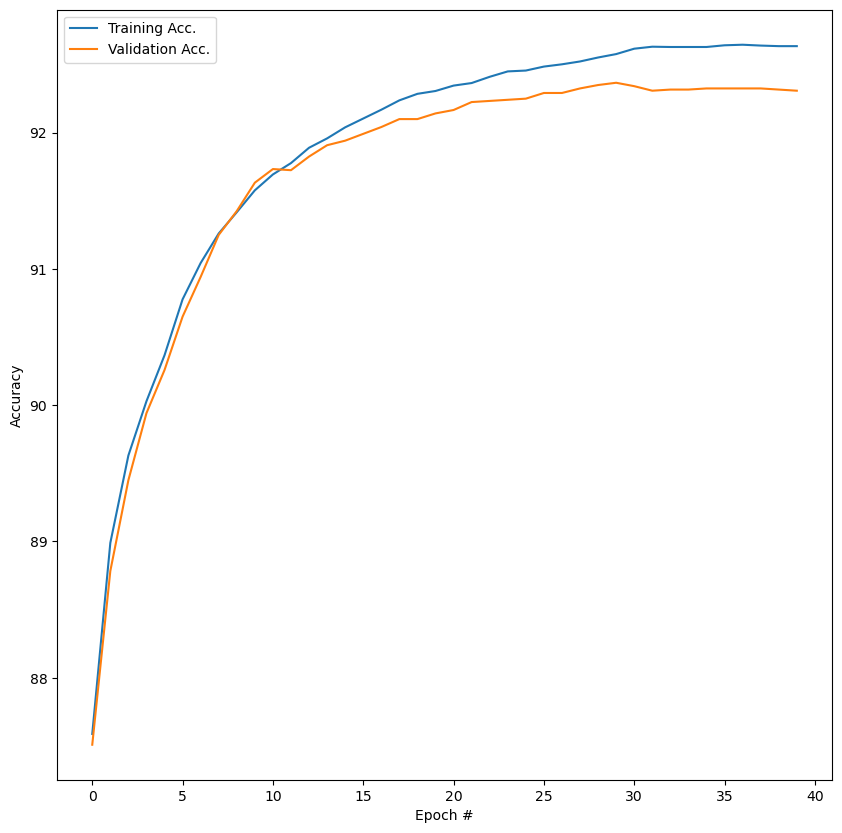

In [17]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(40), train_acc_all,label = 'Training Acc.' )
plt.plot(range(40), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

Now the validation curve has plateaued.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [18]:
#create dataloader for test data
# The dataloader makes our dataset iterable 
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [19]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.2686, test accuracy: 92.39%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [20]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


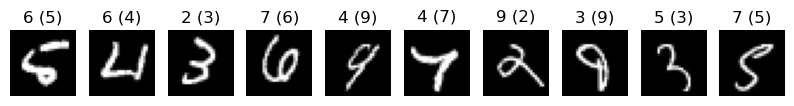

In [21]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn_annotated.jpg"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="images/acc_under_over.webp"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [22]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [23]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [24]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7683273539543152, accuracy: 78.56875
Epoch 0: val. loss: 0.7580159851845275, val. accuracy: 78.38333333333334
Epoch 1: training loss: 0.39829255787531537, accuracy: 88.8375
Epoch 1: val. loss: 0.39131488064502146, val. accuracy: 88.60833333333333
Epoch 2: training loss: 0.3146066019932429, accuracy: 91.04375
Epoch 2: val. loss: 0.3090452604154323, val. accuracy: 90.71666666666667
Epoch 3: training loss: 0.25600188225507736, accuracy: 92.56875
Epoch 3: val. loss: 0.25396529315633976, val. accuracy: 92.26666666666667
Epoch 4: training loss: 0.218629449903965, accuracy: 93.77083333333334
Epoch 4: val. loss: 0.21863457140453318, val. accuracy: 93.38333333333333
CPU times: user 13.3 s, sys: 1.31 s, total: 14.6 s
Wall time: 13.9 s


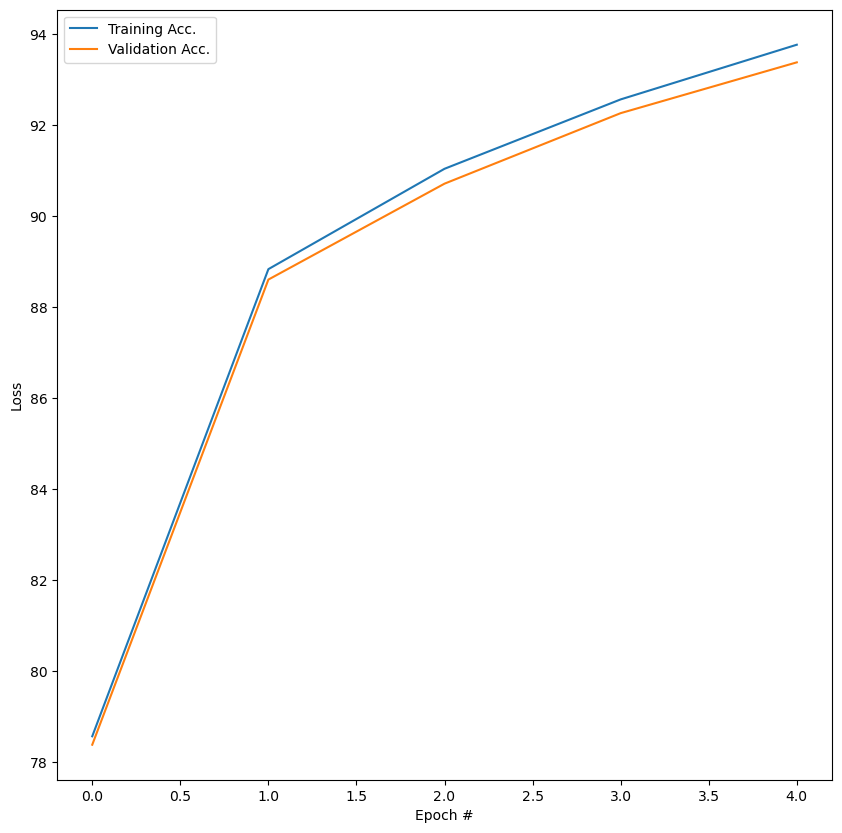

In [25]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


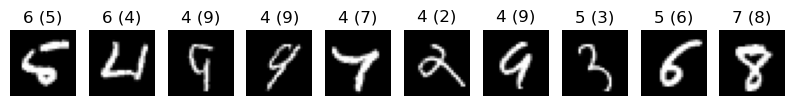

In [26]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes, 
 - learning rates,
 - activation functions.

2. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

In [27]:
def train_model(epochs, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler=None):
    train_acc_all = []
    train_loss_all = []
    val_acc_all = []
    val_loss_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        train_acc_all.append(acc)
        train_loss_all.append(loss)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
        val_acc_all.append(val_acc)
        val_loss_all.append(val_loss)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")
        
        if scheduler is not None:
            scheduler.step()
            
    return {"train": {"loss": train_loss_all, "acc": train_acc_all}, 
            "validation":  {"loss": val_loss_all, "acc": val_acc_all}}

In [28]:
def plot_res(res):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
    n_epochs = len(res['train']['loss'])
    ax[0].plot(range(n_epochs), res['train']['loss'],label = 'Training Loss' )
    ax[0].plot(range(n_epochs), res['validation']['loss'], label = 'Validation Loss' )
    ax[0].set_xlabel('Epoch #')
    ax[0].set_ylabel('Loss')
    ax[1].plot(range(n_epochs), res['train']['acc'],label = 'Training Acc.' )
    ax[1].plot(range(n_epochs), res['validation']['acc'], label = 'Validation Acc.' )
    ax[1].set_xlabel('Epoch #')
    ax[1].set_ylabel('Accuracy')
    plt.legend() 

## Batch sizes

Smaller batch size

In [29]:
batch_size = 64

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [30]:
model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20)

In [31]:
%%time
res = train_model(40, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler)

Epoch 0: training loss: 0.27459109875559806, accuracy: 91.87708333333333
Epoch 0: val. loss: 0.2668498210767482, val. accuracy: 91.975
Epoch 1: training loss: 0.17541580166916051, accuracy: 94.90416666666667
Epoch 1: val. loss: 0.17802419351968676, val. accuracy: 94.59166666666667
Epoch 2: training loss: 0.14153356514622767, accuracy: 95.84791666666666
Epoch 2: val. loss: 0.15651754008982569, val. accuracy: 95.39166666666667
Epoch 3: training loss: 0.11350216916079323, accuracy: 96.57708333333333
Epoch 3: val. loss: 0.13126131464687593, val. accuracy: 95.93333333333334
Epoch 4: training loss: 0.11070447997252146, accuracy: 96.59375
Epoch 4: val. loss: 0.13420665769421675, val. accuracy: 96.05833333333334
Epoch 5: training loss: 0.09761194555585583, accuracy: 97.05208333333334
Epoch 5: val. loss: 0.12271602380961338, val. accuracy: 96.51666666666667
Epoch 6: training loss: 0.0911362754330039, accuracy: 97.2375
Epoch 6: val. loss: 0.1225957035277772, val. accuracy: 96.21666666666667
Epoc

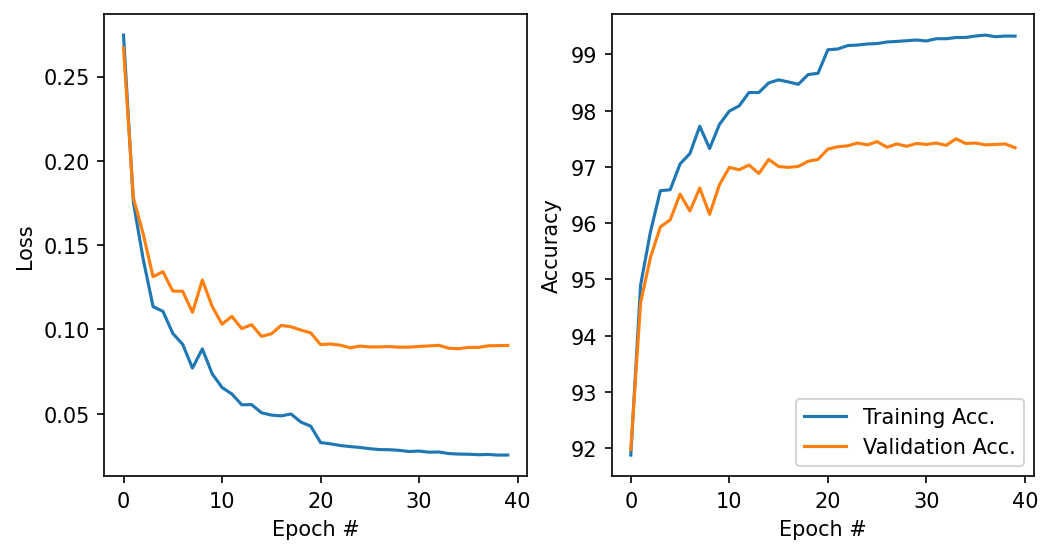

In [32]:
plot_res(res)

In [33]:
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [34]:
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.0832, test accuracy: 97.49%


Larger batch size

In [35]:
batch_size = 256

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [36]:
model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20)

In [37]:
%%time
res = train_model(40, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler)

Epoch 0: training loss: 0.8415227865285062, accuracy: 72.62083333333334
Epoch 0: val. loss: 0.8341736134062422, val. accuracy: 72.85000000000001
Epoch 1: training loss: 0.3867242274449227, accuracy: 89.20625
Epoch 1: val. loss: 0.37657351760154073, val. accuracy: 89.14999999999999
Epoch 2: training loss: 0.31151317979427096, accuracy: 90.99583333333334
Epoch 2: val. loss: 0.3026794597823569, val. accuracy: 90.80833333333334
Epoch 3: training loss: 0.25526091131441137, accuracy: 92.475
Epoch 3: val. loss: 0.24918878744257258, val. accuracy: 92.39166666666667
Epoch 4: training loss: 0.22342828288674355, accuracy: 93.325
Epoch 4: val. loss: 0.22356947368763863, val. accuracy: 93.03333333333333
Epoch 5: training loss: 0.18886417515100318, accuracy: 94.58125
Epoch 5: val. loss: 0.18947412152873708, val. accuracy: 94.46666666666667
Epoch 6: training loss: 0.1676012083412485, accuracy: 95.09791666666668
Epoch 6: val. loss: 0.17234896995285723, val. accuracy: 94.79166666666666
Epoch 7: trainin

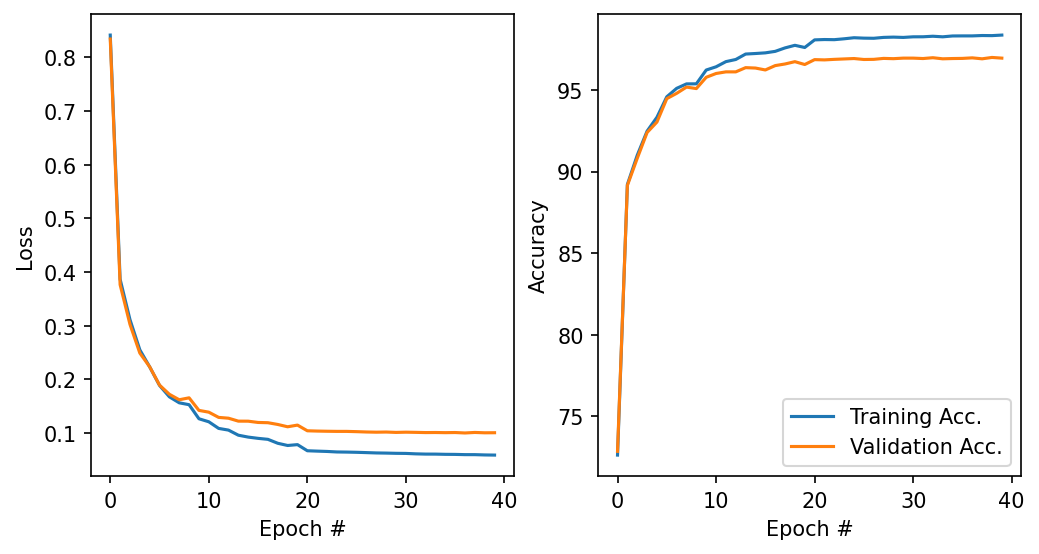

In [38]:
plot_res(res)

In [39]:
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [40]:
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.0983, test accuracy: 96.93%


Significantly smaller batch size

In [41]:
batch_size = 8 

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [42]:
model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20)

In [43]:
%%time
res = train_model(40, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler)

Epoch 0: training loss: 0.20923711018512647, accuracy: 93.94166666666666
Epoch 0: val. loss: 0.21985987773623006, val. accuracy: 93.71666666666667
Epoch 1: training loss: 0.148117776240227, accuracy: 95.8125
Epoch 1: val. loss: 0.16090560941391352, val. accuracy: 95.42500000000001
Epoch 2: training loss: 0.1428908652647524, accuracy: 95.96458333333334
Epoch 2: val. loss: 0.15589151857202765, val. accuracy: 95.72500000000001
Epoch 3: training loss: 0.11836662929718417, accuracy: 96.45625
Epoch 3: val. loss: 0.14196463995842837, val. accuracy: 95.98333333333333
Epoch 4: training loss: 0.11809470526601823, accuracy: 96.46041666666667
Epoch 4: val. loss: 0.1357195833921384, val. accuracy: 96.125
Epoch 5: training loss: 0.11278803409802785, accuracy: 96.75416666666666
Epoch 5: val. loss: 0.1390069400129408, val. accuracy: 96.19166666666666
Epoch 6: training loss: 0.08888706460696176, accuracy: 97.35625
Epoch 6: val. loss: 0.11999332874254712, val. accuracy: 96.58333333333333
Epoch 7: traini

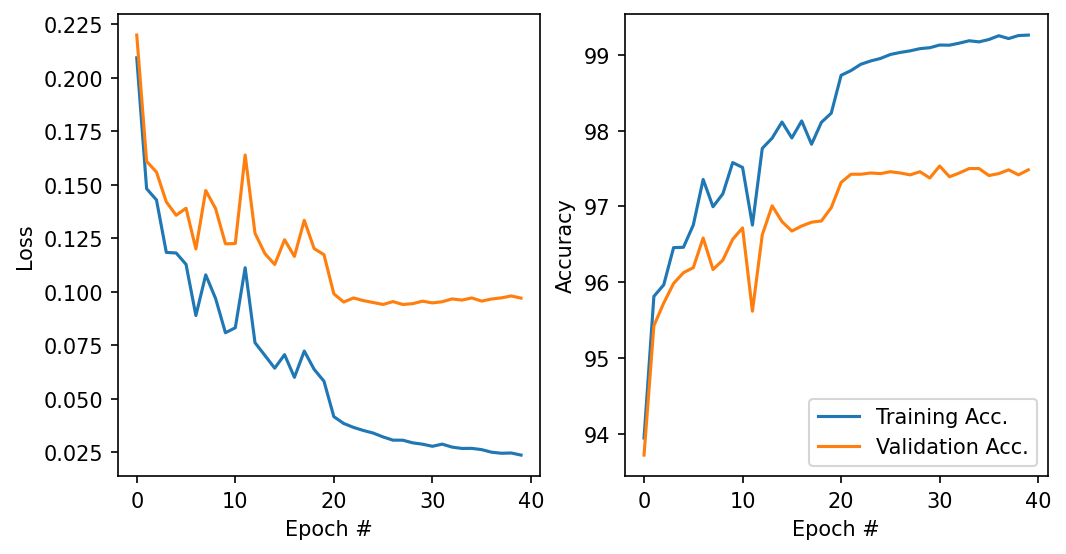

In [44]:
plot_res(res)

In [45]:
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [46]:
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.0976, test accuracy: 97.43%


Not a significant difference between different batch sizes in terms of final accuracy. The training curves for smaller batches tend to be noisier but they converge in fewer epochs as the weights are being updated faster. The trade off is that the training for the smaller batches takes longer.

## Learning rate

As seen in homework 1, a learning rate that is too small leads to slower training while a learning rate that is too large can cause the training to diverge and miss the local minima.

Large learning rate:

In [47]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [48]:
model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [49]:
%%time
res = train_model(40, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler=None)

Epoch 0: training loss: 0.4459288872877757, accuracy: 88.89583333333333
Epoch 0: val. loss: 0.43843162503648314, val. accuracy: 88.79166666666667
Epoch 1: training loss: 0.3535758147637049, accuracy: 89.53750000000001
Epoch 1: val. loss: 0.36131035124367855, val. accuracy: 89.14999999999999
Epoch 2: training loss: 0.3071562600135803, accuracy: 91.40208333333332
Epoch 2: val. loss: 0.31272133201994795, val. accuracy: 91.10000000000001
Epoch 3: training loss: 0.29910579429070155, accuracy: 91.04791666666667
Epoch 3: val. loss: 0.30896734842594636, val. accuracy: 90.80833333333334
Epoch 4: training loss: 0.250120996316274, accuracy: 93.16875
Epoch 4: val. loss: 0.2580129516885636, val. accuracy: 93.01666666666667
Epoch 5: training loss: 0.35605971761544547, accuracy: 89.02083333333334
Epoch 5: val. loss: 0.3691652035142513, val. accuracy: 88.78333333333333
Epoch 6: training loss: 0.271439090569814, accuracy: 91.83541666666667
Epoch 6: val. loss: 0.28419766210495156, val. accuracy: 91.375


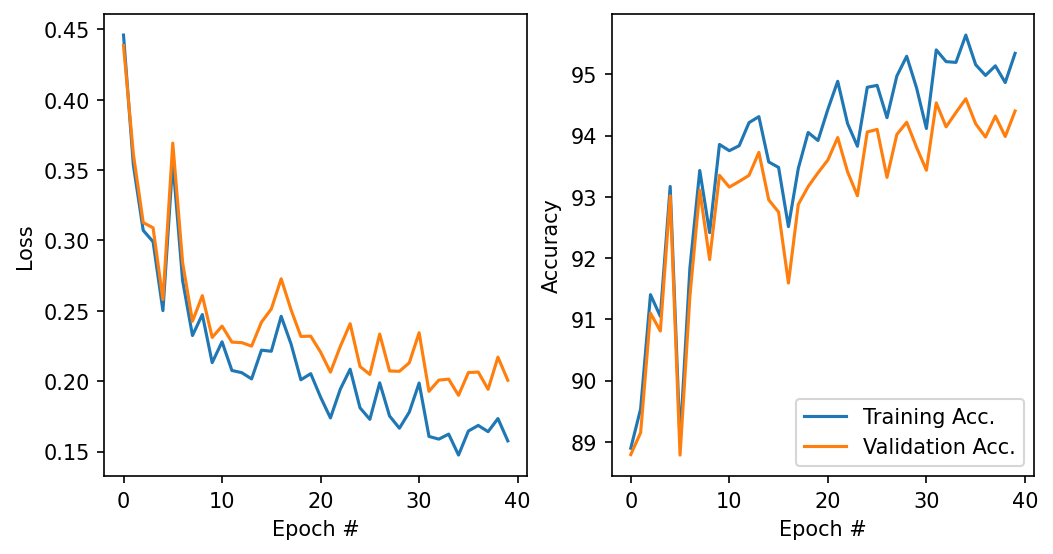

In [50]:
plot_res(res)

In [51]:
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.1996, test accuracy: 94.31%


Very noisy loss trajectory and lower accuracy.

Smaller learning rate

In [52]:
model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [53]:
%%time
res = train_model(40, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler=None)

Epoch 0: training loss: 2.305836919784546, accuracy: 12.2875
Epoch 0: val. loss: 2.304285133138616, val. accuracy: 12.483333333333334
Epoch 1: training loss: 2.3033926474253335, accuracy: 13.439583333333333
Epoch 1: val. loss: 2.301914093342233, val. accuracy: 13.733333333333334
Epoch 2: training loss: 2.3011626637776694, accuracy: 14.595833333333333
Epoch 2: val. loss: 2.2997458919565728, val. accuracy: 15.058333333333335
Epoch 3: training loss: 2.2990168908437094, accuracy: 15.712499999999999
Epoch 3: val. loss: 2.297650545201403, val. accuracy: 16.041666666666668
Epoch 4: training loss: 2.296862310409546, accuracy: 16.664583333333333
Epoch 4: val. loss: 2.2955344103752298, val. accuracy: 17.125
Epoch 5: training loss: 2.29462366549174, accuracy: 17.754166666666666
Epoch 5: val. loss: 2.2933317879413035, val. accuracy: 18.416666666666668
Epoch 6: training loss: 2.292247216542562, accuracy: 21.295833333333334
Epoch 6: val. loss: 2.290993315108279, val. accuracy: 21.9
Epoch 7: training

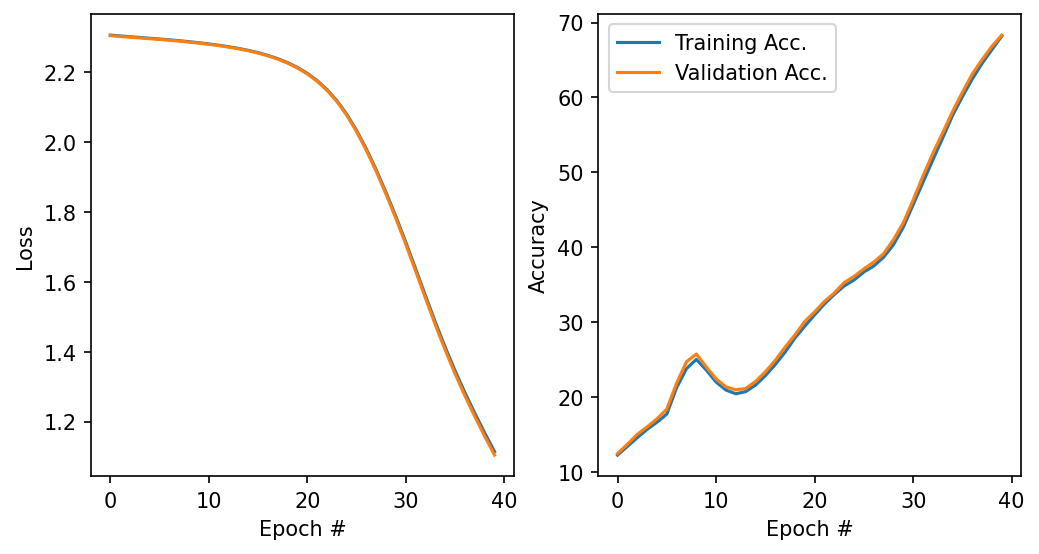

In [54]:
plot_res(res)

In [55]:
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 1.0911, test accuracy: 69.15%


This model will converge, but it takes significantly more epochs to do so.

## Activation functions

### Sigmoid

In [56]:
class NonlinearClassifierSig(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [57]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [58]:
model = NonlinearClassifierSig()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40)

In [59]:
%%time
res = train_model(60, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler)

Epoch 0: training loss: 2.3071428922017416, accuracy: 9.08125
Epoch 0: val. loss: 2.3077680810968926, val. accuracy: 8.85
Epoch 1: training loss: 1.6952636845906575, accuracy: 35.99583333333333
Epoch 1: val. loss: 1.6927117058571348, val. accuracy: 36.175000000000004
Epoch 2: training loss: 0.8145351033210755, accuracy: 76.67500000000001
Epoch 2: val. loss: 0.8081042975821393, val. accuracy: 76.34166666666667
Epoch 3: training loss: 0.5130714686711629, accuracy: 86.55208333333333
Epoch 3: val. loss: 0.5047102262999149, val. accuracy: 86.26666666666667
Epoch 4: training loss: 0.42434125995635985, accuracy: 88.98541666666667
Epoch 4: val. loss: 0.41452939507175, val. accuracy: 88.71666666666667
Epoch 5: training loss: 0.3609831583897273, accuracy: 90.85625
Epoch 5: val. loss: 0.35169873782928956, val. accuracy: 90.77499999999999
Epoch 6: training loss: 0.31140347520510353, accuracy: 92.15208333333334
Epoch 6: val. loss: 0.30303625952690205, val. accuracy: 92.14166666666667
Epoch 7: train

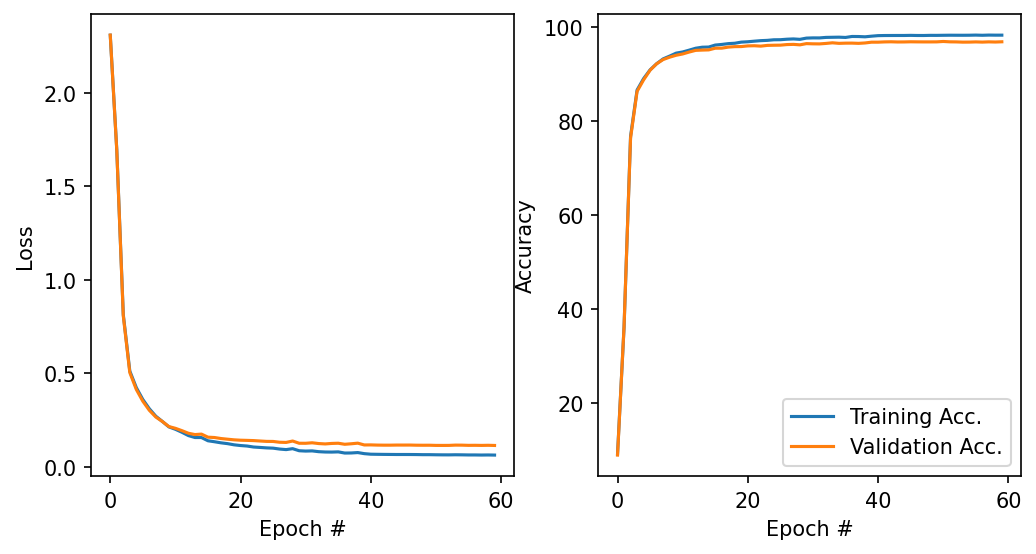

In [60]:
plot_res(res)

In [61]:
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.1181, test accuracy: 96.79%


Sigmoid is slower to train compared to ReLU. Final accuracy is comparable.

### Tanh

In [62]:
class NonlinearClassifierTanh(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [63]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [64]:
model = NonlinearClassifierTanh()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20)

In [65]:
%%time
res = train_model(40, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler)

Epoch 0: training loss: 0.3756498274008433, accuracy: 89.67500000000001
Epoch 0: val. loss: 0.36674049496650696, val. accuracy: 89.78333333333333
Epoch 1: training loss: 0.2912712094783783, accuracy: 91.58541666666666
Epoch 1: val. loss: 0.28414817408044285, val. accuracy: 91.56666666666666
Epoch 2: training loss: 0.24830303233861922, accuracy: 92.80000000000001
Epoch 2: val. loss: 0.24532705688096107, val. accuracy: 92.65
Epoch 3: training loss: 0.2143169520696004, accuracy: 93.70625
Epoch 3: val. loss: 0.21660394966602325, val. accuracy: 93.49166666666666
Epoch 4: training loss: 0.1925783199071884, accuracy: 94.31041666666667
Epoch 4: val. loss: 0.1967892031720344, val. accuracy: 93.93333333333334
Epoch 5: training loss: 0.17783217124144235, accuracy: 94.68541666666667
Epoch 5: val. loss: 0.18435188795023777, val. accuracy: 94.34166666666667
Epoch 6: training loss: 0.15986759422222774, accuracy: 95.16666666666667
Epoch 6: val. loss: 0.1698743546817531, val. accuracy: 94.7250000000000

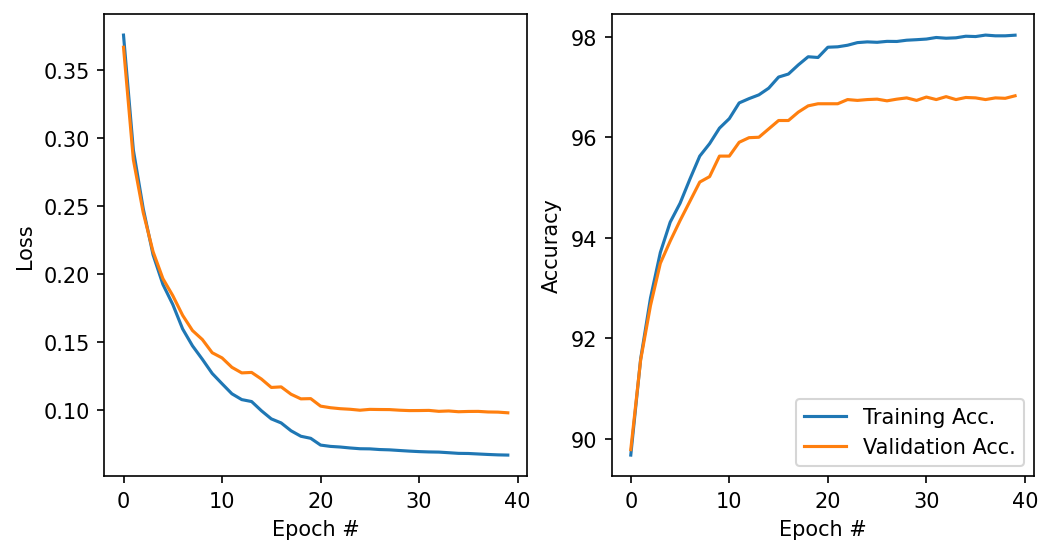

In [66]:
plot_res(res)

In [67]:
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.1010, test accuracy: 96.72%


Tanh performs similarly to ReLU (but has zero gradient issues and is more expensive to compute).

## Bonus question

A learning rate scheduler allows for a variable learning rate during the training epochs. This is particularly useful when the optimizer is close to the local minimum and the reducing the learning rate helps with a more stable decent towards the minimum.

## Improvements

In [73]:
class NonlinearClassifierImp(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [74]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [75]:
model = NonlinearClassifierImp()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [76]:
%%time
res = train_model(50, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler)

Epoch 0: training loss: 0.36468055057525633, accuracy: 89.28958333333334
Epoch 0: val. loss: 0.3575410678031597, val. accuracy: 89.05
Epoch 1: training loss: 0.22982932877540588, accuracy: 93.19791666666667
Epoch 1: val. loss: 0.22528694950519723, val. accuracy: 93.125
Epoch 2: training loss: 0.15608342775702477, accuracy: 95.42500000000001
Epoch 2: val. loss: 0.15812324843508133, val. accuracy: 95.18333333333334
Epoch 3: training loss: 0.12262808857361476, accuracy: 96.375
Epoch 3: val. loss: 0.13055314226670467, val. accuracy: 96.09166666666667
Epoch 4: training loss: 0.10136408774058024, accuracy: 96.91458333333334
Epoch 4: val. loss: 0.11765557030176228, val. accuracy: 96.45
Epoch 5: training loss: 0.0774137155910333, accuracy: 97.7375
Epoch 5: val. loss: 0.09821587216426084, val. accuracy: 96.95833333333333
Epoch 6: training loss: 0.06596884101380905, accuracy: 98.07291666666667
Epoch 6: val. loss: 0.09034677831693849, val. accuracy: 97.23333333333333
Epoch 7: training loss: 0.054

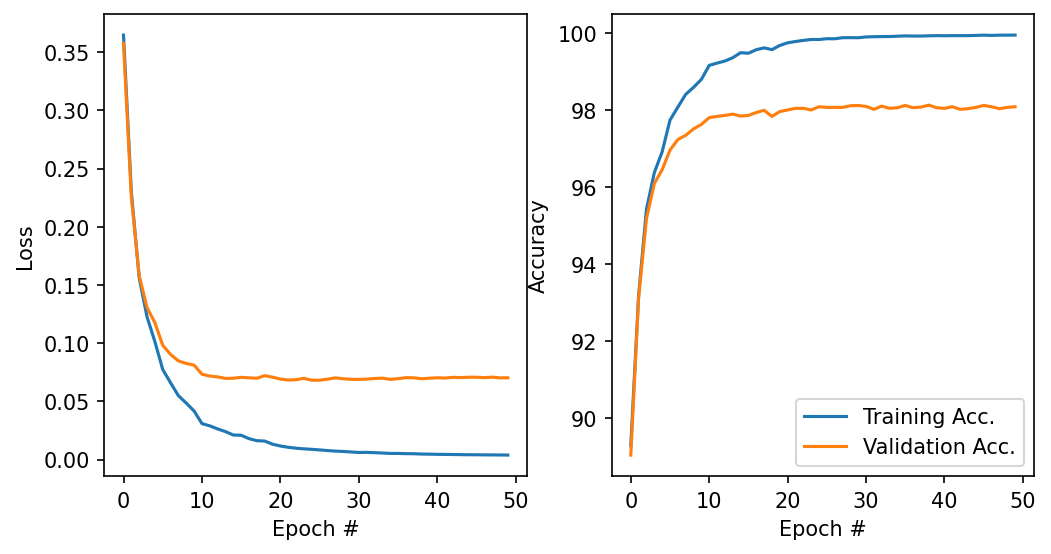

In [77]:
plot_res(res)

In [78]:
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [79]:
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.0672, test accuracy: 98.10%


1% accuracy increase by using a more complicated network and a more aggresive dropout layer.